In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().system('pip install db-dtypes')
get_ipython().system('pip install xgboost')
get_ipython().system('pip install prophet')
get_ipython().system('pip install plotly')
get_ipython().system('pip install plotly-geo')
get_ipython().system('pip install geopandas')
get_ipython().system('pip install pyshp')
get_ipython().system('pip install shapely')

In [3]:
import datetime
import itertools
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory
import plotly.subplots

In [4]:
import statsmodels.api as sm
import sklearn.experimental.enable_iterative_imputer
import sklearn.impute
import sklearn.ensemble
import sklearn.model_selection
import sklearn.linear_model
import xgboost as xgb

In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

In [7]:
# define relevant columns based on categories 
COL_MAP = {
    'edu': ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown'],
    'race': ['race_amerindian', 'race_asian', 'race_black', 'race_noanswer', 'race_hawaiiannative', 'race_other', 'race_white'],    
    'gender': ['gender_female', 'gender_male', 'gender_na'],
    'industry': ['top_category_employer1', 'top_category_employer2', 'top_category_employer3']        
}

In [8]:
def get_cols(names):
    l = []
    for name in names:
        if name in COL_MAP:
            l += COL_MAP[name]
        else:
            l += [name]
    return l

In [9]:
def subset(df, uu_id_idx):        
    return df.loc[df.uu_id == df.uu_id.unique()[uu_id_idx], :]

In [10]:
def convert_to_submission(results_csv, week_number_to_submit=40):
    r = pd.read_csv(results_csv)
    last = r.loc[r.week_number == week_number_to_submit, ['uu_id', 'predicted']]
    last.index = last.uu_id
    uuid_map = last.to_dict(orient='dict')['predicted']
    p = query('prediction_list')
    p['total_claims'] = p['uu_id'].map(uuid_map)
    p.to_csv('submission_prediction_output.csv', index=False)

In [11]:
def get_county(tract_name):
    m = re.search('Census Tract \S+, (.+) County, Indiana', tract_name)
    county = m.group(1)
    return county

In [12]:
def query(table):
    bigquery_client = bigquery.Client(project='ironhacks-data')
    query_str = f'''
SELECT *
FROM `ironhacks-data.ironhacks_competition.{table}`
'''
    query_job = bigquery_client.query(query_str)
    data = query_job.to_dataframe()
    return data

In [13]:
def combine(u, w):
    '''
    Joins the unemployment data and the wage data on `uu_id`
    '''
    ww = w.loc[:, ['uu_id', 'average_wage']]
    d = u.join(ww.set_index('uu_id'), on='uu_id')
    return d

In [14]:
def load_raw(csv_name='0_raw.csv'):
    '''
    Loads the unemployment and wage data and does some basic cleaning
    '''
    if not os.path.isfile(csv_name):
        u = query('unemployment_data')
        w = query('wage_data')
        raw = combine(u, w)
        raw.to_csv(csv_name, index=False)
    else:
        raw = pd.read_csv(csv_name)
    raw['county'] = raw['tract_name'].apply(get_county)
    raw = raw.drop(['tract', 'timeperiod', 'tract_name'], axis=1)
    raw = raw.sort_values(by=['uu_id', 'week_number'])
    raw = raw.drop_duplicates()
    raw = raw.replace({np.nan: None})
    raw = raw.reset_index(0, drop=True)
    return raw

In [15]:
load_raw().to_dict('records')[0]

{'uu_id': '001cd9ae23064d7f0fd3cd327c873d8d',
 'week_number': 31,
 'countyfips': 18099,
 'total_claims': 34,
 'edu_8th_or_less': None,
 'edu_grades_9_11': 0.0,
 'edu_hs_grad_equiv': 30.0,
 'edu_post_hs': None,
 'edu_unknown': 0.0,
 'top_category_employer1': '31-33',
 'top_category_employer2': '23',
 'top_category_employer3': '81',
 'gender_female': None,
 'gender_male': None,
 'gender_na': 0.0,
 'race_amerindian': 0.0,
 'race_asian': 0.0,
 'race_black': 0.0,
 'race_noanswer': 0.0,
 'race_hawaiiannative': 0.0,
 'race_other': 0.0,
 'race_white': 34.0,
 'average_wage': 10484.333333333334,
 'county': 'Marshall'}

In [16]:
def get_week_number_map(g, colname):
    '''
    Creates a dictionary that maps from week number to an existing value in a given `colname`
    '''
    g = g[['week_number', colname]]
    week_number_map = dict(sorted(g.values.tolist()))
    return week_number_map

In [17]:
def week_number_to_date(week_number, first_week_date='20220101'):
    '''
    Prepare a date column for ARIMA
    '''
    return pd.to_datetime(first_week_date, format='%Y%m%d') + pd.DateOffset(days=7*(week_number - 1))

In [18]:
def insert_na_week_number(g, min_week_number='min', max_week_number=37):
    d = {}
    if min_week_number == 'min':
        week_number_min = g.week_number.min()
    else:
        week_number_min = min_week_number
    for colname in g.columns:
        week_number_map = get_week_number_map(g, colname)
        series = pd.Series(range(week_number_min, max_week_number+1))        
        d[colname] = series.map(week_number_map)        
    
    df = pd.DataFrame(d)
    df['week_number'] = range(week_number_min, max_week_number+1)
    df['uu_id'] = [v for v in df['uu_id'].unique() if type(v) == str][0]
    df['average_wage'] = [v for v in g['average_wage'].unique()][0]
    df['countyfips'] = [v for v in g['countyfips'].unique()][0]
    df['county'] = [v for v in g['county'].unique() if type(v) == str][0]
    return df

In [19]:
def load_raw_full(csv_name='1_raw_full.csv'):
    if not os.path.isfile(csv_name):
        raw = load_raw()
        raw_full = raw.groupby('uu_id').apply(insert_na_week_number).reset_index(0, drop=True)
        raw_full['date'] = raw_full['week_number'].apply(week_number_to_date)        
        raw_full.to_csv(csv_name, index=False)
    else:
        raw_full = pd.read_csv(csv_name)
    return raw_full

In [20]:
load_raw_full()[['uu_id', 'week_number', 'total_claims']]

,uu_id,week_number,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,1,NaN
1,001cd9ae23064d7f0fd3cd327c873d8d,2,NaN
2,001cd9ae23064d7f0fd3cd327c873d8d,3,NaN
3,001cd9ae23064d7f0fd3cd327c873d8d,4,NaN
4,001cd9ae23064d7f0fd3cd327c873d8d,5,NaN
...,...,...,...
22570,fec479d0202d6e1e3f051a9ee902ff5d,39,NaN
22571,fec479d0202d6e1e3f051a9ee902ff5d,40,NaN
22572,fec479d0202d6e1e3f051a9ee902ff5d,41,NaN
22573,fec479d0202d6e1e3f051a9ee902ff5d,42,NaN


In [21]:
import prophet

ModuleNotFoundError: No module named 'prophet'

In [22]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [23]:
def run_prophet(g, period=0, growth='linear', changepoint_range=0.8, n_changepoints=100, changepoint_prior_scale=0.75, seasonality_mode='additive', seasonality_prior_scale=10.0):
    g = g.reset_index(0, drop=True)
    gg = g.copy()
    x = pd.DataFrame({'ds': gg['date'], 'y': np.log(gg['total_claims']), 'cap': np.log(gg['total_claims']).max()})
    model = prophet.Prophet(
        weekly_seasonality=False,
        changepoint_range=changepoint_range,  
        n_changepoints=n_changepoints, 
        changepoint_prior_scale=changepoint_prior_scale,
        growth=growth,
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        )
    if period:
        model.add_seasonality(name='monthly', period=30, fourier_order=period)
        model.add_seasonality(name='quarterly', period=90, fourier_order=period)
        model.add_seasonality(name='yearly', period=365, fourier_order=period)
    pred = model.fit(x).predict(x)
    gg['predicted'] = np.exp(pred.yhat)
    gg['predicted'] = gg['predicted'].clip(lower=0, upper=gg['total_claims'].max())
    gg['total_claims_imputed'] = gg['total_claims'].fillna(gg['predicted'])
    return gg

In [24]:
def plot_prophet(n=12):
    d = load_raw_full()
    ncols = 6
    nrows = int(np.ceil(n/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), sharex=True)
    for i in range(n):
        if i % 10 == 0:
            print(i)
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]
        dd = subset(d, i)
        ax.plot(dd.week_number, dd.total_claims, 'o', label='raw')
        for growth in ['logistic', 'linear']:            
            pred = run_prophet(dd, growth=growth)
            pp = pred.loc[pred.total_claims.isna(), :]
            ax.plot(pp.week_number, pp.predicted, 'o', label=f'fb: {growth}')
        if idx_row == 0 and idx_col == ncols - 1:
            ax.legend()
        if idx_row == nrows - 1:
            ax.set_xlabel('week_number')
        if idx_col == 0:
            ax.set_ylabel('claims')

0


NameError: name 'prophet' is not defined

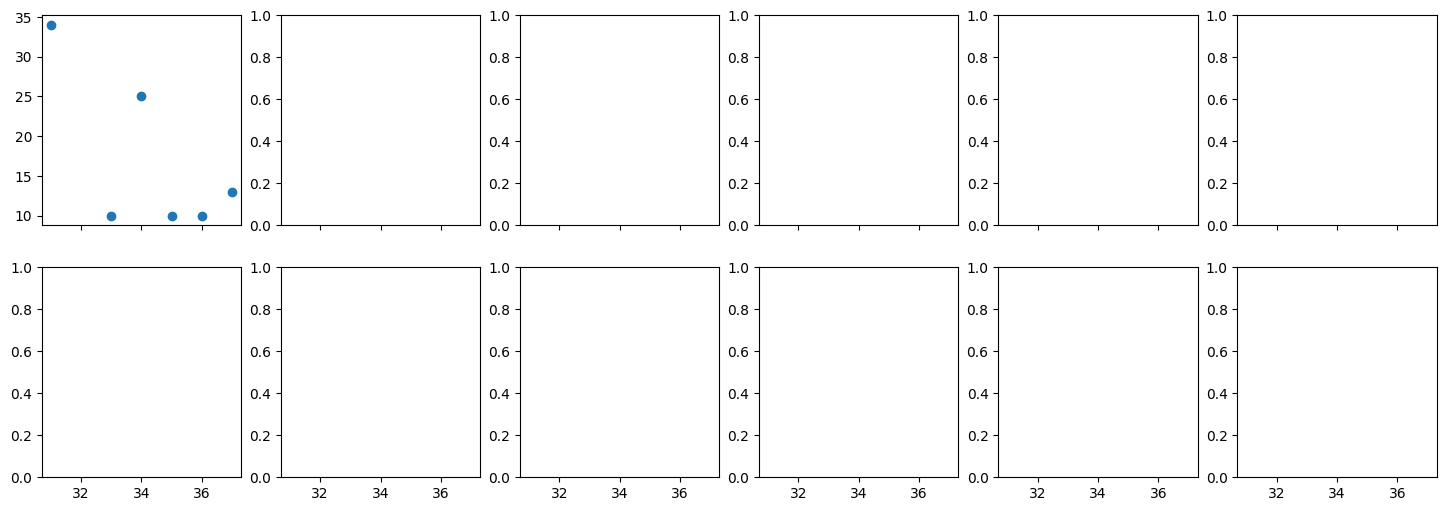

In [25]:
plot_prophet(n=12)

In [26]:
def load_imp_tot(csv_name='2_imp_tot.csv'):
    if not os.path.isfile(csv_name):
        raw = load_raw_full()
        l = []
        for i, (uu_id, g) in enumerate(raw.groupby('uu_id')):
            if i % 20 == 0:
                print(i)
            gg = run_prophet(g, growth='linear')
            gg['total_claims'] = gg['total_claims_imputed']
            l.append(gg)
        d = pd.concat(l, ignore_index=True)
        d = d.drop(['predicted', 'total_claims_imputed'], axis=1)
        d.to_csv(csv_name, index=False)        
    else:
        d = pd.read_csv(csv_name)
    return d

In [27]:
def plot_impute(n=6):
    raw = load_raw_full()
    imp = load_imp_tot()
    fig, axs = plt.subplots(ncols=n, sharey=False, figsize=(n*3, 3))
    for i in range(n):
        rraw = subset(raw, i)
        iimp = subset(imp, i)
        ax = axs[i]
        ax.plot(rraw.week_number, rraw.total_claims, 'o', label='original')
        ax.plot(iimp.week_number, iimp.total_claims, '-', label='imputed')
        ax.set_xlim(0, 42)
        ax.set_xlabel('week_number')
    axs[0].set_ylabel('claims')
    axs[-1].legend(fancybox=False)    

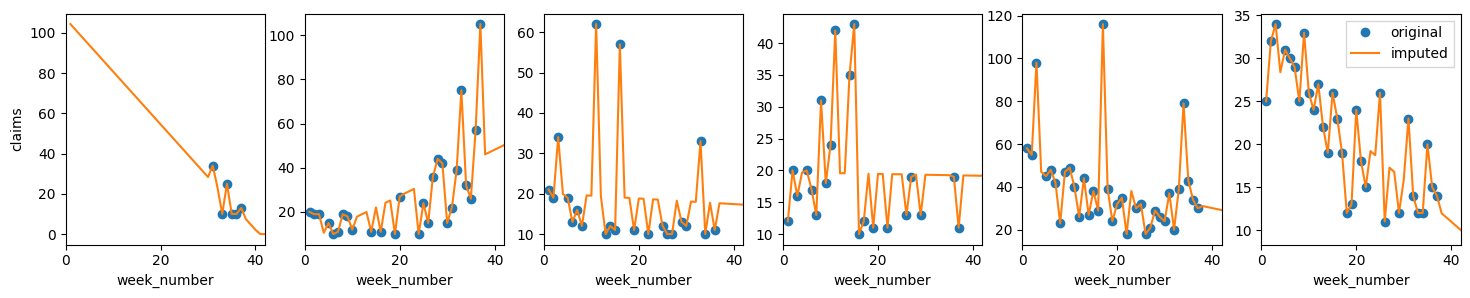

In [28]:
plot_impute()

In [29]:
def load_county():
    d = load_imp_tot()
    l = []
    for (county, week_number), g in d.groupby(['county', 'week_number']):        
        l.append({
            'county': county,
            'fips': g.countyfips.values[0],
            'week_number': week_number,
            'total_claims': g.total_claims.mean()
        })
    c = pd.DataFrame(l)
    return c

In [30]:
def avg_weeks(c, start, end):
    mask = (start <= c.week_number) & (c.week_number <= end)
    cc = c.loc[mask, :]

In [31]:
load_county()

KeyError: 'county'

In [32]:
def plot_counties(cc, week_number):
    fips = cc.fips
    values = cc.total_claims
    # endpts = list(np.mgrid[min(values):max(values):4j])
    endpts = [15, 30, 45, 60]
    colorscale = [
        'rgb(239,239,239)',
        'rgb(195, 196, 222)',
        'rgb(144,148,194)',
        'rgb(101,104,168)',
        'rgb(65, 53, 132)'
    ]
    fig = plotly.figure_factory.create_choropleth(
        fips=fips, values=values, scope=['Indiana'], show_state_data=True,
        colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        legend_title=f'Average total claims by county for week {week_number}',
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
        exponent_format=True,
    )
    fig.layout.template = None
    fig.show()
    return fig

In [33]:
def plot_county_all():
    c = load_county()
    week_numbers = [1, 18, 36]
    for i, week_number in enumerate(week_numbers):
        cc = c.loc[c.week_number == week_number, :]
        plot_counties(cc, week_number)

In [34]:
plot_county_all()

KeyError: 'county'

In [35]:
def load_extrap(csv_name='3_extrap.csv'):
    if not os.path.isfile(csv_name):
        d = load_imp_tot()
        c = load_county()
        l = []
        for uu_id, g in d.groupby('uu_id'):
            g = insert_na_week_number(g, min_week_number=1).reset_index(0, drop=True)
            fips = g['countyfips'].values[0]
            cc = c.loc[c.fips==fips, :].reset_index(0, drop=True)
            g['total_claims'] = g['total_claims'].fillna(cc.total_claims)
            l.append(g)
        extrap = pd.concat(l, ignore_index=True)
        extrap['date'] = extrap['week_number'].apply(week_number_to_date)
        extrap.to_csv(csv_name, index=False)
    else:
        extrap = pd.read_csv(csv_name)
    return extrap

In [36]:
load_extrap()[get_cols(['uu_id', 'week_number', 'total_claims', 'gender'])]

KeyError: 'county'

In [37]:
def replace_na_cols(g):
    '''
    If a column only has None or zero values, replace that entire columnn with zeros
    '''
    x = g.copy()
    for col in g.columns:
        cond1 = g[col].isnull()
        cond2 = g[col] == 0
        if (cond1 | cond2).all():
            x[col] = 0        
    return x

In [38]:
def impute_iterative(df):
    '''
    Wrapper fucntion for IterativeImputer for a generic data frame. 
    Mostly, for testing. We might need need this function
    Impute data assuming there are zero columns where all the values are NA
    '''
    imputer = sklearn.impute.IterativeImputer(random_state=0, min_value=0)
    imputed_cols = imputer.fit_transform(df)
    df_imputed = pd.DataFrame(imputed_cols, columns=df.columns)
    return df_imputed

In [39]:
def iter_cat(g):
    g = replace_na_cols(g)    
    for cat in ['edu', 'race', 'gender']:
        gg = g.loc[:, COL_MAP[cat] + ['total_claims']]
        yield cat, gg

In [40]:
def print_impute_cat(test_subset, impute_func):
    for cat, gg in iter_cat(test_subset):
        line = '*'*len(cat)
        print(line)
        print(cat)
        print(line)
        print(impute_func(gg).head())

In [41]:
print_impute_cat(subset(load_extrap(), 6), impute_iterative)

KeyError: 'county'

In [42]:
def impute_rowsum(df, target_col='total_claims'):
    l = []
    for idx, row in df.iterrows():
        n_unknowns = row.isna().sum()        
        if n_unknowns == 1:
            others = row[~row.isna() & (row.index != target_col)]
            val = row[target_col] - others.sum()
            val = val if val > 0 else 0
            row[row.isna()] = val
        l.append(row)
    df = pd.DataFrame(l).reset_index(0, drop=True)
    
    l = []
    for idx, row in df.iterrows():
        n_unknowns = row.isna().sum()        
        
        weights = {}
        for col in row[row.isna()].index:
            weights[col] = df[col].mean()
        weights = {k:v/sum(weights.values()) for k, v in weights.items()}       
        
        if n_unknowns > 1:            
            others = row[~row.isna() & (row.index != target_col)]
            row[row.isna()] = row[row.isna()].index.map(weights)*(row[target_col] - others.sum())            
        l.append(row)
        
    df_imputed = pd.DataFrame(l).reset_index(0, drop=True)
    return df_imputed

In [43]:
print_impute_cat(subset(load_extrap(), 6), impute_rowsum)

KeyError: 'county'

In [44]:
def impute_all(df):
    x = df.copy().reset_index(0, drop=True)
    for cat, gg in iter_cat(df):
        df_imputed = impute_rowsum(gg)
        df_imputed = df_imputed.drop('total_claims', axis=1)
        x[COL_MAP[cat]] = df_imputed
    return x

In [45]:
def load_imp_feature(csv_name='4_imp_feature.csv'):
    if not os.path.isfile(csv_name):
        imp_tot = load_extrap()
        imp = imp_tot.groupby('uu_id').apply(impute_all).reset_index(0, drop=True)
        imp['date'] = imp['week_number'].apply(week_number_to_date)
        imp.to_csv(csv_name, index=False)
    else:
        imp = pd.read_csv(csv_name)
    return imp

In [46]:
load_imp_feature().to_dict('records')[0]

KeyError: 'county'

In [47]:
def impute_logistic(g, ycol):
    g = g[[ycol, 'week_number', 'total_claims']]
    xcols = ['week_number', 'total_claims']
    ycols = [ycol]
    
    mask_train = ~g[ycol].isnull()
    x_train, x_test = g.loc[mask_train, xcols], g.loc[~mask_train, xcols]
    y_train, y_test = g.loc[mask_train, ycols], g.loc[~mask_train, ycols]
    
    if y_train.shape[0] == 0:
        g[ycol] = None
        return g[ycol]
    
    classes = y_train[ycol].unique()
    if len(classes) == 1:
        yhat = [classes[0]]
    else:
        model = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000).fit(x_train, y_train.values.ravel())
        yhat = model.predict(x_test)
    g.loc[~mask_train, ycols] = yhat
    return g[ycol]

In [48]:
def impute_industry(g, max_week_number=37):
    g = g.loc[g.week_number <= max_week_number, :]
    x = g.copy()
    for colname in COL_MAP['industry']:
        x[colname] = impute_logistic(g, colname)
    return x

In [49]:
def load_imp_industry(csv_name='5_imp_industry.csv'):
    if not os.path.isfile(csv_name):
        d = load_imp_feature()
        d = d.groupby('uu_id').apply(impute_industry).reset_index(0, drop=True)
        d.to_csv(csv_name, index=False)
    else:
        d = pd.read_csv(csv_name)
    return d

In [50]:
load_imp_industry().isna().sum()

KeyError: 'county'

In [51]:
def feature_engineer(d):
    d['gender_male_ratio'] = d['gender_male'] / d['total_claims']
    d['edu_post_hs_ratio'] = d['edu_post_hs'] / d['total_claims']
    d['race_white_ratio'] = d['race_white'] / d['total_claims']
    d['race_black_ratio'] = d['race_black'] / d['total_claims']
    d = d.drop(get_cols(['gender', 'edu', 'race']), axis=1)
    return d

In [52]:
def load_featured(csv_name='6_featured.csv'):
    if not os.path.isfile(csv_name):
        d = load_imp_industry()
        d = feature_engineer(d)
        d.to_csv(csv_name, index=False)
    else:
        d = pd.read_csv(csv_name)
    return d

In [53]:
load_featured().to_dict('records')[0]

KeyError: 'county'

In [54]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [55]:
def arimax(y, order, seasonal_order, exog=None):
    model = sm.tsa.statespace.SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(maxiter=300, disp=False)
    return results

In [56]:
def get_best_params(y, exog=None, period=0, steps=2):
    r1 = r2 = r3 = range(steps)
    pdq = list(itertools.product(r1, r2, r3))    
    if period:
        seasonal_pdq = [(x[0], x[1], x[2], period) for x in list(itertools.product(r1, r2, r3))]
    else:
        seasonal_pdq = [(0, 0, 0, 0)]
    aic_min = np.inf
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            results = arimax(y, order, seasonal_order, exog=exog)
            if results.aic < aic_min:
                aic_min = results.aic
                best_params = [order, seasonal_order, results.aic]            
    return best_params

In [57]:
def predict(g, exog=False, ylabel='total_claims', target_week_number=43):
    g = g.set_index('date')
    g.index = pd.DatetimeIndex(g.index).to_period('W')
    y = g[ylabel].astype(np.float64)
    x = g[['edu_post_hs_ratio', 'gender_male_ratio', 'race_white_ratio', 'race_black_ratio']]
    if exog:
        best_params = get_best_params(y, exog=x)
    else:
        best_params = get_best_params(y)
    best_results = arimax(y, best_params[0], best_params[1])    
    pred = best_results.get_prediction(start=week_number_to_date(target_week_number - 10), end=week_number_to_date(target_week_number), dynamic=False)
    
    x = g.join(pred.predicted_mean, on=g.index, how='outer')
    x['date'] = x.key_0
    ci = pred.conf_int()
    x['ci_lower'] = ci.iloc[:, 0]
    x['ci_upper'] = ci.iloc[:, 1]
    x['uu_id'] = g['uu_id'].values[0]
    x['predicted'] = x['predicted_mean']
    x = x.reset_index(0, drop=True)
    return x

In [58]:
def predict_all(d, ylabel, csv_name, exog=False):
    l = []
    for i, (uu_id, g) in enumerate(d.groupby('uu_id')):    
        if i % 100 == 0:
            print(f'processed {i} UUIDs')
        predicted = predict(g, ylabel=ylabel, exog=exog)
        l.append(predicted)        
    df = pd.concat(l, ignore_index=True)
    df.to_csv(csv_name, index=False)

In [59]:
if not os.path.isfile('results_arima.csv'):
    predict_all(load_featured(), 'total_claims', 'results_arima.csv')

In [60]:
if not os.path.isfile('results_arimax.csv'):
    predict_all(load_featured(), 'total_claims', 'results_arimax.csv', exog=True)

KeyError: 'county'

In [61]:
def plot_arima(n=6):
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(3*n, 3))
    res_arima = pd.read_csv('results_arima.csv')
    res_arimax = pd.read_csv('results_arimax.csv')
    raw = load_featured()
    for i in range(n):
        ax = axs[i]
        rraw = subset(raw, i)
        rres_arima = subset(res_arima, i)
        rres_arimax = subset(res_arimax, i)
        ax.plot(rraw.week_number, rraw.total_claims, 'o-', label='raw')
        ax.plot(rres_arima.week_number, rres_arima.predicted, 'o-', label='arima')
        ax.plot(rres_arimax.week_number, rres_arimax.predicted, 'o-', label='arimax')
        ax.set_xlim(0, 42)
        ax.set_xlabel('week_number')
        ax.set_ylim(0, None)
    axs[0].set_ylabel('claims')
    axs[-1].legend(fancybox=False)

FileNotFoundError: [Errno 2] No such file or directory: 'results_arimax.csv'

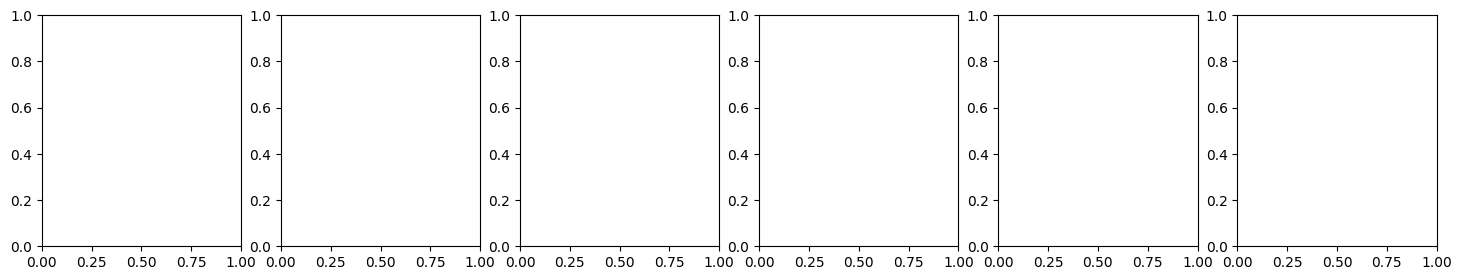

In [62]:
plot_arima()

In [63]:
convert_to_submission('results_arima.csv', week_number_to_submit=37)

In [64]:
def get_train_test(g, split_week_number=30):
    xcols = ['edu_post_hs_ratio', 'gender_male_ratio', 'race_white_ratio', 'race_black_ratio', 'week_number']
    ycols = ['total_claims']    
    mask_train = g.week_number <= split_week_number
    mask_test = ~mask_train
    
    x_train, x_test = g.loc[mask_train, xcols], g.loc[mask_test, xcols]
    y_train, y_test = g.loc[mask_train, ycols], g.loc[mask_test, ycols]
    return x_train, x_test, y_train, y_test

In [65]:
def run_rf(g, split_week_number=30):
    x_train, x_test, y_train, y_test = get_train_test(g, split_week_number=split_week_number)
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=0).fit(x_train, y_train.values.ravel())
    yhat = rf.predict(pd.concat([x_train, x_test]))
    return x_train, x_test, y_train, y_test, yhat

In [66]:
def plot_rf(d):
    fig, axs = plt.subplots(ncols=6, figsize=(18, 3), sharey=True)
    for i in range(6):
        ax = axs[i]
        dd = subset(d, i)
        
        x_train, x_test, y_train, y_test, yhat = run_rf(dd)
        ax.plot(x_train.week_number, y_train, 'o-', label='original')
        ax.plot(dd.week_number, yhat, 'o-', label='predict')
        ax.set_xlabel('week_number')
        ax.set_title(f'uu_id: {i}')
        ax.set_xlim(0, 42)
            
    axs[-1].legend(frameon=False)
    axs[0].set_ylabel('claims')
    plt.show()

In [67]:
plot_rf(load_featured())

KeyError: 'county'

In [68]:
def rf_industry(g):
    uu_id = g.uu_id.values[0]
    gg = g[COL_MAP['industry'] + ['week_number', 'total_claims']]    
    gg = gg.dropna()
    gg = pd.get_dummies(gg)
        
    if gg.shape[0] == 0:
        print(g.uu_id.values[0])
        mean = g.total_claims.mean()
        return pd.DataFrame([{'uu_id': uu_id, 'week_number': 38, 'total_claims': mean, 'predicted': mean}])
    x = gg.drop(['total_claims'], axis=1)    
    y = gg['total_claims']    
    max_avail_week_number = int(x.week_number.max())
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=0).fit(x, y.values.ravel())
    last = x.loc[x.week_number == max_avail_week_number, :].copy()
    last['week_number'] = max_avail_week_number + 1
    x_test = pd.concat([x, last], ignore_index=True)
    x_test['predicted'] = rf.predict(x_test)
    result = x_test.copy()
    result['total_claims'] = y.reset_index(0, drop=True)
    result['uu_id'] = uu_id
    return result[['uu_id', 'week_number', 'total_claims', 'predicted']]

In [69]:
def plot_industry(d):
    fig, axs = plt.subplots(ncols=6, figsize=(18, 3), sharey=True)
    for i in range(6):
        ax = axs[i]
        dd = subset(d, i)
        result = rf_industry(dd)
        ax.plot(result.week_number, result.total_claims, 'o-', label='original')
        ax.plot(result.week_number, result.predicted, 'o-', label='predict')
        ax.set_xlabel('week_number')
        ax.set_title(f'uu_id: {i}')
        ax.set_xlim(0, 42)
            
    axs[-1].legend(frameon=False)
    axs[0].set_ylabel('claims')
    plt.show()

In [70]:
plot_industry(load_featured())

KeyError: 'county'

In [71]:
def run_rf_all(d, csv_name='results_rf.csv'):
    if not os.path.isfile(csv_name):
        result_rf = d.groupby('uu_id').apply(rf_industry).reset_index(0, drop=True)
        result_rf.to_csv(csv_name, index=False)

In [72]:
run_rf_all(load_featured())

KeyError: 'county'

In [73]:
def get_train_test(g):    
    xcols = ['edu_post_hs_ratio', 'gender_male_ratio', 'race_white_ratio', 'race_black_ratio', 'week_number']
    ycols = ['total_claims']
    mask_train = g.week_number <= 30
    mask_test = ~mask_train
    g_train = g.loc[mask_train, :]
    g_test = g.loc[mask_test, :]
    
    x_train = g_train[xcols]
    y_train = g_train[ycols]
    x_test = g_test[xcols]
    y_test = g_test[ycols]
    return x_train, y_train, x_test, y_test

In [74]:
def run_xgb_old(g, params={'n_estimators': 1000}):
    uu_id = g.uu_id.values[0]
    x_train, y_train, x_test, y_test = get_train_test(g)
    reg = xgb.XGBRegressor(objective='reg:squarederror', **params)
    reg.fit(x_train, y_train, verbose=True)
    yhat = reg.predict(x_test)
    x_test['predicted'] = yhat
    x_test['uu_id'] = uu_id
    return x_test

In [75]:
def optimize_xgb(g):
    uu_id = g.uu_id.values[0]
    x, y, x_test = get_train_test(g)
    # params = {
    #     'min_child_weight': [1, 5, 10],
    #     'gamma': [0.3, 0.5, 1.0, 1.5, 2.0, 5.0],
    #     'subsample': [0.6, 0.8, 1.0],
    #     'colsample_bytree': [0.6, 0.8, 1.0],
    #     'max_depth': [2, 3, 4, 5],
    #     'n_estimators': [300, 600, 1000],
    #     'learning_rate': [0.001, 0.01, 0.1]
    # }
    params = {
        'min_child_weight': [1],
        'gamma': [0.3],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3],
        'n_estimators': [600, 1000]        
    }
    reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
    grid = sklearn.model_selection.GridSearchCV(reg, params)
    grid.fit(x, y)
    yhat = grid.best_estimator_.predict(x_test)
    x_test['predicted'] = yhat
    x_test['uu_id'] = uu_id
    return x_test, grid.best_score_, grid.best_params_

In [76]:
def plot_xgb(d, n=6):    
    fig, axs = plt.subplots(ncols=n, figsize=(18, 3), sharey=True)
    for i in range(n):
        ax = axs[i]
        g = subset(d, i)
        pred = run_xgb_old(g)
        # pred, best_score, best_params = optimize_xgb(g)
        # print(i)
        # print(f'best score: {best_score}')
        # print('best_param: ', best_params)
        ax.plot(g.week_number, g.total_claims, 'o-', label='raw')
        ax.plot(pred.week_number, pred.predicted, 'o-', label='xgboost')
        ax.set_xlim(0, 42)
        ax.set_xlabel('week_number')
    axs[0].set_ylabel('claims')
    axs[-1].legend(fancybox=False)

In [77]:
plot_xgb(load_featured())

KeyError: 'county'

In [78]:
def preprocess_xgb(d):
    d = d[['total_claims', 'uu_id', 'average_wage', 'week_number', 'edu_post_hs_ratio', 'gender_male_ratio', 'race_white_ratio', 'race_black_ratio']].copy()
    # d = get_dummies(d, COL_MAP['industry'])
    d['date'] = d['week_number'].apply(week_number_to_date)
    d['month'] = d['date'].dt.month
    d['quarter'] = d['date'].dt.quarter
    nlags = 3
    d['mean_month'] = d.groupby('month')['total_claims'].transform(lambda x: float(x.dropna().mean()))
    d['mean_quarter'] = d.groupby('quarter')['total_claims'].transform(lambda x: float(x.dropna().mean())) 
    
    for lag in range(1, nlags + 1):        
        d[f'shift_{lag}'] = d.groupby('uu_id')['total_claims'].transform(lambda x: x.shift(lag))
    
    d = d.drop(['date'], axis=1)    
    encoder = sklearn.preprocessing.LabelEncoder()
    d['uu_id'] = encoder.fit_transform(d['uu_id'].astype(str))
    d = d.dropna()
    return d

In [79]:
preprocess_xgb(load_featured())

KeyError: 'county'

In [80]:
def get_train_test_xgb(g):
    mask_train = g.week_number <= 30
    mask_test = ~mask_train
    x_cols = g.columns.difference(['total_claims'])
    y_cols = ['total_claims']
    x_train = g.loc[mask_train, x_cols]
    y_train = g.loc[mask_train, y_cols]
    x_test = g.loc[mask_test, x_cols]
    y_test = g.loc[mask_test, y_cols]
    return x_train, y_train, x_test, y_test

In [81]:
def run_xgb(g, params={'n_estimators': 1000}):
    x_train, y_train, x_test, y_test = get_train_test_xgb(g)
    reg = xgb.XGBRegressor(objective='reg:squarederror', **params)
    reg.fit(x_train, y_train, verbose=True)
    yhat = reg.predict(x_test)
    x_test['predicted'] = yhat
    x_test['total_claims'] = y_test
    return x_test

In [82]:
def plot_xgb(n=6):    
    pp = preprocess_xgb(load_featured())
    res = run_xgb(pp)
    
    ncols = 6
    nrows = int(np.ceil(n/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), sharex=True)
    for i in range(n):
        if i % 10 == 0:
            print(i)
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]
        ppp = pp.loc[pp.uu_id == pp.uu_id.unique()[i], :]
        rres = res.loc[res.uu_id == res.uu_id.unique()[i], :]
        ax.plot(ppp.week_number, ppp.total_claims, 'o-', label='raw')
        ax.plot(rres.week_number, rres.predicted, 'o-', label='xgboost')
        ax.set_xlim(0, 42)
        ax.set_xlabel('week_number')
        if idx_col == 0:
            ax.set_ylabel('claims')
        if idx_col == ncols - 1:
            ax.legend(fancybox=False)

In [83]:
plot_xgb(n=24)

KeyError: 'county'